In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [2]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 99% 15.0M/15.1M [00:01<00:00, 21.3MB/s]
100% 15.1M/15.1M [00:01<00:00, 15.0MB/s]


In [8]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from zipfile import ZipFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

In [7]:
# Import the ResNet50 model
from tensorflow.keras.applications import ResNet50

Done


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,211,714 (99.99 MB)

 Trainable params: 2,624,002 (10.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 84s 13s/step - accuracy: 0.5485 - loss: 1.5196 - val_accuracy: 0.6071 - val_loss: 1.0274 - learning_rate: 0.0010
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 61s 10s/step - accuracy: 0.6484 - loss: 0.8388 - val_accuracy: 0.4405 - val_loss: 0.7842 - learning_rate: 0.0010
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 77s 9s/step - accuracy: 0.4876 - loss: 0.7864 - val_accuracy: 0.6071 - val_loss: 0.8089 - learning_rate: 0.0010
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.6404 - loss: 0.6952 - val_accuracy: 0.6905 - val_loss: 0.6119 - learning_rate: 0.0010
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 82s 9s/step - accuracy: 0.6676 - loss: 0.6082 - val_accuracy: 0.6190 - val_loss: 0.6292 - learning_rate: 0.0010
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 84s 11s/step - accuracy: 0.6764 - loss: 0.6003 - val_accuracy: 0.7619 - val_loss: 0.5337 - learning_rate: 0.0010
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 54s 9s/step - accuracy: 0.6918 - loss: 0.5652 - val_accuracy: 0.7262 - val_loss: 0.5

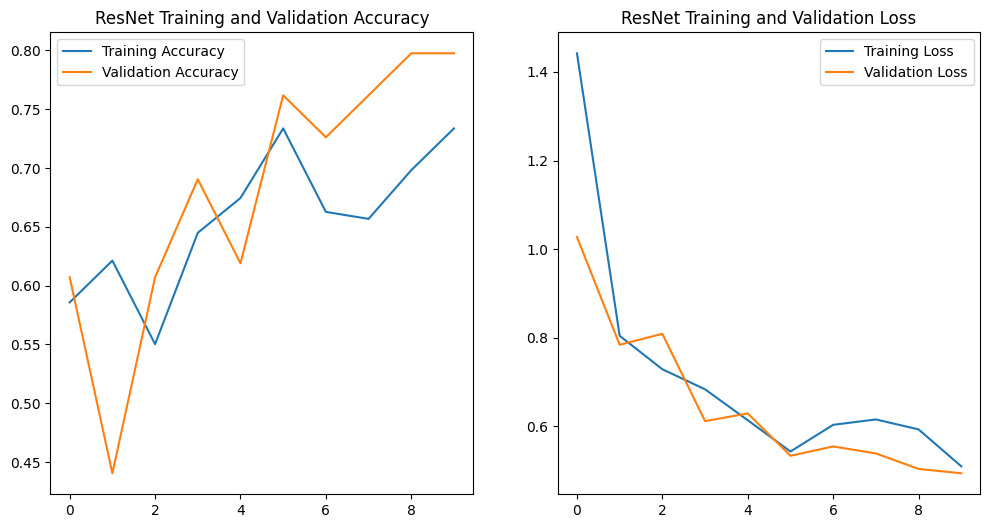

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 205s 27s/step - accuracy: 0.6772 - loss: 0.9383 - val_accuracy: 0.7976 - val_loss: 0.5064 - learning_rate: 1.0000e-05
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 187s 28s/step - accuracy: 0.7343 - loss: 0.7385 - val_accuracy: 0.7976 - val_loss: 0.5226 - learning_rate: 1.0000e-05
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 197s 23s/step - accuracy: 0.7711 - loss: 0.5074 - val_accuracy: 0.7976 - val_loss: 0.5431 - learning_rate: 1.0000e-05
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 206s 24s/step - accuracy: 0.8286 - loss: 0.4234 - val_accuracy: 0.7976 - val_loss: 0.5975 - learning_rate: 1.0000e-05
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 145s 24s/step - accuracy: 0.8306 - loss: 0.3815 - val_accuracy: 0.7381 - val_loss: 0.6603 - learning_rate: 1.0000e-05
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 202s 24s/step - accuracy: 0.8433 - loss: 0.3835 - val_accuracy: 0.6786 - val_loss: 0.7127 - learning_rate: 1.0000e-05
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 205s 25s/step - accuracy: 0.8907 - loss:

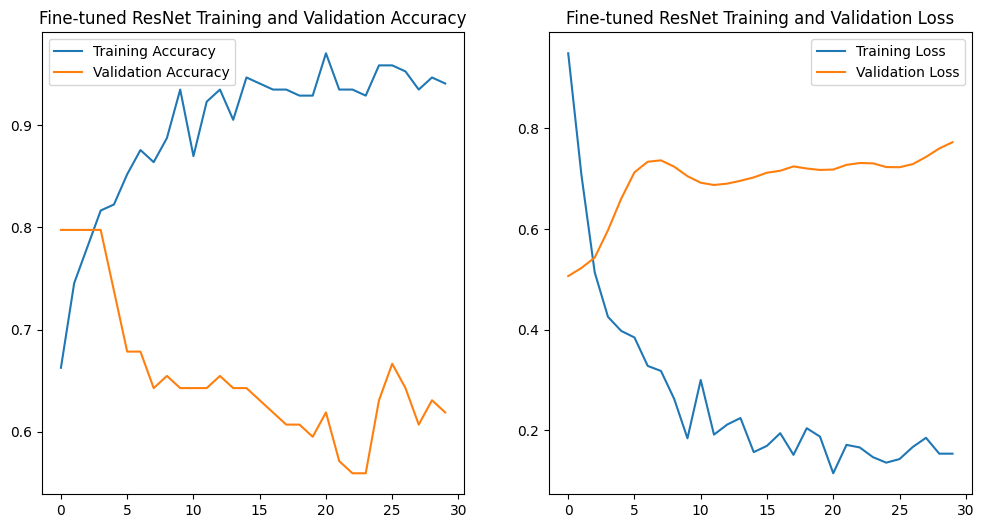

In [14]:
# Unzip the dataset
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('Done')

# Load images and labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (224, 224))
            img = img / 255.0  # Normalize pixel values to [0, 1]
            images.append(img)
            labels.append(label)
    return images, labels

X_yes, y_yes = load_images_from_folder('/content/yes', 'Y')
X_no, y_no = load_images_from_folder('/content/no', 'N')

X = X_yes + X_no
y = y_yes + y_no

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Preprocessing for standardization
def preprocess_input(x):
    return (x - np.mean(x)) / np.std(x)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# Apply Gaussian blur as part of preprocessing
def apply_gaussian_blur(images):
    blurred_images = []
    for img in images:
        blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
        blurred_images.append(blurred_img)
    return np.array(blurred_images)

X_train_blurred = apply_gaussian_blur(X_train)
X_test_blurred = apply_gaussian_blur(X_test)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

# Build the ResNet model with fine-tuning
def build_resnet_model(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_resnet = build_resnet_model(num_classes=2)
model_resnet.summary()

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with ResNet using flow() from ImageDataGenerator
history_resnet = model_resnet.fit(
    datagen.flow(X_train_blurred, y_train, batch_size=32),
    validation_data=(X_test_blurred, y_test),
    epochs=10,
    callbacks=[lr_scheduler],
    verbose=1
)

# Plot the training and validation accuracy for ResNet
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('ResNet Training and Validation Loss')
plt.legend()

plt.show()

# Fine-tune some of the top layers of the ResNet model
for layer in model_resnet.layers[:15]:  # Freeze layers until layer 15
    layer.trainable = False
for layer in model_resnet.layers[15:]:  # Unfreeze the rest
    layer.trainable = True

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the fine-tuned ResNet model
fine_tune_history_resnet = model_resnet.fit(
    datagen.flow(X_train_blurred, y_train, batch_size=32),
    validation_data=(X_test_blurred, y_test),
    epochs=30,
    callbacks=[lr_scheduler],
    verbose=1
)

# Plot the fine-tuned training and validation accuracy for ResNet
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tune_history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-tuned ResNet Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fine_tune_history_resnet.history['loss'], label='Training Loss')
plt.plot(fine_tune_history_resnet.history['val_loss'], label='Validation Loss')
plt.title('Fine-tuned ResNet Training and Validation Loss')
plt.legend()

plt.show()